# Behavioral Exploration:
# Topic Modeling and SNR
 
Exploring the research question: what effect does modifying the input corpus have on the ability to do topic modeling?

TASKS:

- Build the system.
- Test the system under various constraints & make observations about its behaviour.

## Sections

The notebook first establishes a fixed topic model (generic LDA). Then, it defines some properties of corpora that may be modified during experiments. It loads a few corpora and examines their properties. The generic topic model is used to extract topics from these corpora. Performance metrics for the topic model that may be affected by changes in the corpora are defined and calculated on the corpora.

- [Section 1: A Fixed Approach](#1-A-Fixed-Approach)
- [Section 2: Corporus Characteristics](#2-Corpus-Characteristics)
- [Section 3: Choosing Corpora](#3-Choosing-Corpora)
  - [Section 3.1: Wine Reviews](#3.1-Wine-Reviews)
  - [Section 3.2: Brown](#3.2-Brown)
  - [Section 3.3: ABC](#3.3-ABC)
- [Section 4: Performance Metrics](#4-Performance-Metrics)
- [Section 5: Exploring Results](#5-Exploring-Results)

# 1 A Fixed Approach

This section constructs a baseline model for topic-modeling that is up-to-date on the latest settings for optimal performance. The most widely used and successful topic-modeling approach is [Latent Dirichlet Allocation]() [Blei].

It performs best under the following settings:
- Asymmetric Alpha
- Symmetric Beta

The appropriate number of topics is still somewhat up in the air. Beli et al. say K should be less than the number of documents. TBD is an upper bound on K.

An interesting experiment would be to see on which K the Brown corpus converges since this is theorized to be a relatively broad sample of the English language. It begs the research question, How many topics are there in the Human language?

In [186]:
from sklearn.decomposition import LatentDirichletAllocation

k = 100
alpha = 1/k
beta = 1/k

# TODO: MAKE ALPHA ASYMMETRIC
lda = LatentDirichletAllocation(n_components=k,
                                doc_topic_prior=alpha,
                                topic_word_prior=beta,
                                learning_method='online')

# These two will be a useful later when we want to explore the topics
def get_top_words(model, feature_names, n_top_words=10):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        sorted_top = topic.argsort()[:-n_top_words-1:-1]
        top_words[topic_idx] = [feature_names[i] for i in sorted_top]
    return top_words

def print_top_words(model, feature_names, n_top_words=10):
    top_words = get_top_words(lda,feature_names,n_top_words)
    for topic in top_words:
        words = ' '.join(top_words[topic])
        print("Topic_{}: {}".format(topic,words))

# 2 Corpus Characteristics

I decided it would be easier to define an new corpus reader object that extends NLTK's existing PlaintextCorpusReader. This can be found in `corpus.py`. It extends PlaintextCorpusReader by adding characteristics to the corpus so that the user can ask basic questions like how many documents are there? What is their average word count? A lot of the characteristics are straightforward. For those that aren't, an explanation is provided.

So far the characteristics I have defined are:
- Number of documents
- Average document length (in words)
- Vocab size
- Readability ([smog index](https://en.wikipedia.org/wiki/SMOG))
- Distance from uniform distribution
- [Lexical diversity](http://textinspector.com/help/?page_id=136)
- Stopword presence (what percentage of the corpus is stopwords?)

Still TODO are:
- Stability
- Inherent Topics

# 3 Choosing Corpora

In this section I'm going to load some various real-world corpora and test out the different metrics. This is really the __behavioural exploration__ section. After fixing any bugs in the metrics, I'll start making some initial observations of the system to see if I can find hints of phenomena or correlations.

## 3.1 Wine Reviews

This first corpus is a collection of wine reviews. It's an example of a small corpus with short-text documents. Unfortunately they've all been joined into one big file so we need to do a little manual labour to separate the individual short reviews. This means creating a new nltk corpus reader object from the one big wine review document.

In [161]:
import os

from nltk.corpus import webtext
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

wine_doc = webtext.raw('wine.txt')

# Individual reviews are split by newline characters
wine_reviews = list(filter(None,wine_doc.split('\n')))

if not os.path.exists('wine_files'):
    os.makedirs('wine_files')
    
fileids = []
for i in range(len(wine_reviews)):
    fn = '{:04}.txt'.format(i)
    fileids.append(fn)
    with open(os.path.join('wine_files',fn),'w') as f:
        f.write(wine_reviews[i])
    f.close()
wine_cr = PlaintextCorpusReader('wine_files',
                                fileids,
                                word_tokenizer=webtext._word_tokenizer,
                                sent_tokenizer=webtext._sent_tokenizer,
                                para_block_reader=webtext._para_block_reader,
                                encoding=webtext._encoding)

Now let's convert the new corpus reader into a PropertiesCorpusReader object and explore its characteristics. 

In [166]:
from corpus import PropertiesCorpusReader
wine_pcr = PropertiesCorpusReader(wine_cr)

Calculating properties...
	Readability calculated.
	Distance from uniform calculated.
	Lexical diversity calculated.
	Stopword presence calculated.


In [173]:
wine_pcr.print_properties()

Number of documents: 1230
Average document length: 25.494309
Vocab size: 3417
Readability: 276.148311
Distance from uniform: 0.868652
Lexical diversity: 0.108967
Stopword presence: 0.261305


After gathering characteristics of the corpus, the next step is to see how well the generic LDA model can decipher topics from it.

In [187]:
from sklearn.feature_extraction.text import CountVectorizer

print("Converting document(s) into term-frequency matrix...")
tf_vectorizer = CountVectorizer(stop_words='english')
data_samples = wine_pcr.raw_docs()
tf = tf_vectorizer.fit_transform(data_samples)

print("Fitting LDA to matrix...")
lda.fit(tf)

print("Done.")

Converting document(s) into term-frequency matrix...
Fitting LDA to matrix...
Done.


In [188]:
print_top_words(lda,tf_vectorizer.get_feature_names())

Topic_0: depth lacking stuff modern complexity unoaked pricey mahogany trouble ok
Topic_1: tautness begining varieties admiring birthday passionate colombier 1990 stirred carries
Topic_2: rated corked promising finest shiraz thought tasting austrere peak whites
Topic_3: oxidation dull hours early case premature 24 dumb gingery decanter
Topic_4: beginning dry fruit liquorice amontillado forgotten decanter overlying somewhat including
Topic_5: juiciness maturing phase guess lacking vintage wines fruit steely varieties
Topic_6: unnoticeable spritz slight drinking pleasant mature world used mixed trademark
Topic_7: little keen woody showing striking lot toffee expecting complex extracted
Topic_8: dry better reputation given vintage nice crianza texture suppose larose
Topic_9: wine good quite bare fruit bit interesting like rich touch
Topic_10: fat raspberry coarseness bacon glimpses awkwardness occasional toned opens pure
Topic_11: tuck convinced bought oloroso sunny expanded wonder short 

The following gathers the matrices we need to calculating model performance. They are:
- topic word distribution, a.k.a. what is the likelihood of a given word in each topic?
- document word distribution, a.k.a. what is the count of each word in the documents (this is a sparse matrix)
- document topic distribution, a.k.a. the proportion of each document that is made up by each topic

In [192]:
wine_topic_word = lda.components_.copy()
wine_topic_word.shape

(100, 2589)

In [193]:
wine_doc_word = tf.copy()
wine_doc_word.shape

(1230, 2589)

In [195]:
wine_doc_topic = lda.transform(wine_doc_word)
wine_doc_topic.shape

(1230, 100)

In [197]:
wine_features = tf_vectorizer.get_feature_names().copy()
len(wine_features)

2589

The next step is to calculate model performance metrics using the above arrays/matrices.

## 3.2 Brown

The Brown corpora is probably one of the most famous ones out there. It's the polar opposite of the wine reviews because instead of a few short documents, it has a lot of long documents. Which means it takes a really long time to build a PropertiesCorpusRedaer object of it, so verbosity is a nice sanity check while it's running.

In [177]:
from nltk.corpus import brown
brown_pcr = PropertiesCorpusReader(brown)

Calculating properties...
	Readability calculated.
	Distance from uniform calculated.
	Lexical diversity calculated.
	Stopword presence calculated.


In [178]:
brown_pcr.print_properties()

Number of documents: 500
Average document length: 2322.384000
Vocab size: 66939
Readability: 11.327279
Distance from uniform: 0.970922
Lexical diversity: 0.057647
Stopword presence: 0.000000


In [198]:
from sklearn.feature_extraction.text import CountVectorizer

print("Converting document(s) into term-frequency matrix...")
tf_vectorizer = CountVectorizer(stop_words='english')
data_samples = brown_pcr.raw_docs()
tf = tf_vectorizer.fit_transform(data_samples)

print("Fitting LDA to matrix...")
lda.fit_transform(tf)

print("Done.")

Converting document(s) into term-frequency matrix...
Fitting LDA to matrix...
Done.


In [200]:
print_top_words(lda,tf_vectorizer.get_feature_names())

Topic_0: twos granther building recherche eliminating yamata devotedly scobee varnessa nihilistic
Topic_1: casca caucusing middles williamson christy imaginatively baraclough titus deluded certifying
Topic_2: religiosity brochures sacrosanct hercule month orbital giselle gennaro whitely amazed
Topic_3: nn np jj tl nns vb cc rb vbn vbd
Topic_4: hoy tableland viola scimitars northers memorizing violinists skimpy bentham chicago
Topic_5: nn nns vb jj ppss cc np vbd pps pp
Topic_6: col virtuous jealousies semitic retiring accommodate virtuosi cennini viale attentions
Topic_7: juror rutted quake window pruta schnapps taruffi untrammeled trachea ki
Topic_8: competitive 355 tamp ryder trinitarians rehash barrel unerring 1831 bigots
Topic_9: carson lies migs flouting qualified zhok conveyed politburo balling july
Topic_10: hans nan crops chockfull sugared gums sorrow daring kerosene immature
Topic_11: auditorium panama demodocus contorted turandot reforms meddling edw expressionist seclusion
T

Get the same matrices we got when we did the wine reviews to use for performance calculations.

In [201]:
brown_topic_word = lda.components_.copy()
brown_doc_word = tf.copy()
brown_doc_topic = lda.transform(brown_doc_word)
brown_features = tf_vectorizer.get_feature_names()

## 3.3 ABC

A corpus of news files.

In [288]:
from nltk.corpus import abc
abc_pcr = PropertiesCorpusReader(abc)

Calculating properties...
	Readability calculated.
	Distance from uniform calculated.
	Lexical diversity calculated.
	Stopword presence calculated.


In [289]:
abc_pcr.print_properties()

Number of documents: 2
Average document length: 383405.500000
Vocab size: 31885
Readability: 12.119386
Distance from uniform: 0.942461
Lexical diversity: 0.041581
Stopword presence: 0.349936


In [292]:
from sklearn.feature_extraction.text import CountVectorizer

print("Converting document(s) into term-frequency matrix...")
tf_vectorizer = CountVectorizer(stop_words='english')
data_samples = [abc_pcr.raw(d) for d in abc_pcr.fileids()]
tf = tf_vectorizer.fit_transform(data_samples)

print("Fitting LDA to matrix...")
lda.fit_transform(tf)

print("Done.")

Converting document(s) into term-frequency matrix...
Fitting LDA to matrix...
Done.


In [293]:
abc_topic_word = lda.components_.copy()
abc_doc_word = tf.copy()
abc_doc_topic = lda.transform(abc_doc_word)
abc_features = tf_vectorizer.get_feature_names()

# 4 Performance Metrics

Metrics should adhere to the following axioms:
- Similar models or topics should have similar scores.
- Different models or topics should have differing scores.
- Scores should change when the model changes.

We should also consider metrics that have been tested in previous work to rule them in/out as informative of performance. 

In addition, metrics should be able to be calculated on any matrices regardless of how they were created (using LDA or not).

So far, the metrics defined are:
- Exclusivity
- [Jensen-Shannon Divergence](https://stackoverflow.com/questions/15880133/jensen-shannon-divergence
- Effective size
- Average word length
- Rank1

Still TODO are:
- Classification
- Point-wise mutual information
- Coherence
- SNR

When possible, metrics are calculated separately for each individual topic.

PMI source:

[Newman et al. 2011](http://papers.nips.cc/paper/4291-improving-topic-coherence-with-regularized-topic-models.pdf)

In [299]:
from metrics import *

def get_metrics(dw=None,dt=None,tw=None,fn=None,k=100):
    metrics_dic = {}
    
    awl = []
    ex = []
    r1 = []
    dfu = []
    
    # Individual topic metrics
    for i in range(k):
        awl.append(average_word_length(tw[i],fn))
        ex.append(exclusivity(tw,i))
        r1.append(rank1(dt,i))
        dfu.append(distance_from_uniform(tw[i]))
    
    metrics_dic['average_word_length'] = awl
    metrics_dic['exclusivity'] = ex
    metrics_dic['rank1'] = r1
    metrics_dic['distance_from_uniform'] = dfu
    
    return metrics_dic

In [300]:
wine_metrics = get_metrics(dw=wine_doc_word,
                           dt=wine_doc_topic,
                           tw=wine_topic_word,
                           fn=wine_features)

In [301]:
brown_metrics = get_metrics(dw=brown_doc_word,
                            dt=brown_doc_topic,
                            tw=brown_topic_word,
                            fn=brown_features)

In [303]:
abc_metrics = get_metrics(dw=abc_doc_word,
                          dt=abc_doc_topic,
                          tw=abc_topic_word,
                          fn=abc_features)

# 5 Exploring Results

Since LDA is a BOW model, the words themselves are not important for most measures (except complexity).

For complexity, we know what affects the complexity score. If we modify that, how does LDA performance change?

TODO: Find/generate corpora that satisfy the characteristics defined above and train the baseline model on them.

In [304]:
%matplotlib notebook

import matplotlib.pyplot as plt

## 5.1 Number of Documents

Explore how corpus properties affect performance.

Independent variable: corpus properties
Dependent variable: performance metrics

__QUESTION:__ Which do we compare to which...which to hold?

In [305]:
prop_dic = {'num_docs':(brown_pcr.num_docs,wine_pcr.num_docs,abc_pcr.num_docs),
            'avg_doc_len':(brown_pcr.avg_doc_len,wine_pcr.avg_doc_len,abc_pcr.avg_doc_len),
            'lexical_diversity':(brown_pcr.lexical_diversity,wine_pcr.lexical_diversity,abc_pcr.lexical_diversity),
            'stopword_presence':(brown_pcr.stopword_presence,wine_pcr.stopword_presence,abc_pcr.stopword_presence),
            'readability':(brown_pcr.readability,wine_pcr.readability,abc_pcr.readability),
            'vocab_size':(brown_pcr.vocab_size,wine_pcr.vocab_size,abc_pcr.vocab_size),
            'distance_from_uniform':(brown_pcr.distance_from_uniform,wine_pcr.distance_from_uniform,abc_pcr.distance_from_uniform)}

In [306]:
def plot_property(prop_name,x_brown,x_wine,x_abc):
    metrics = ['average_word_length','exclusivity',
               'distance_from_uniform','rank1']
    f,axarr = plt.subplots(2,2)
    i = 0
    j = 0
    for metric in metrics:
        axarr[i,j].scatter(x_brown,brown_metrics[metric],color='blue',alpha=0.5,label='Brown')
        axarr[i,j].scatter(x_wine,wine_metrics[metric],color='darkorange',alpha=0.5,label='Wine')
        axarr[i,j].scatter(x_abc,abc_metrics[metric],color='green',alpha=0.5,label='ABC')
        axarr[i,j].set_title(metric)
        # this works. just accept it.
        i+=1
        j+=i%2
        j%=2
        i%=2
    plt.legend()
    plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
    plt.setp([a.get_xticklabels() for a in axarr[1, :]], rotation=45)
    plt.tight_layout()
    plt.savefig('figures/{}_metrics.png'.format(prop_name),dpi=300)
    plt.show()

<IPython.core.display.Javascript object>


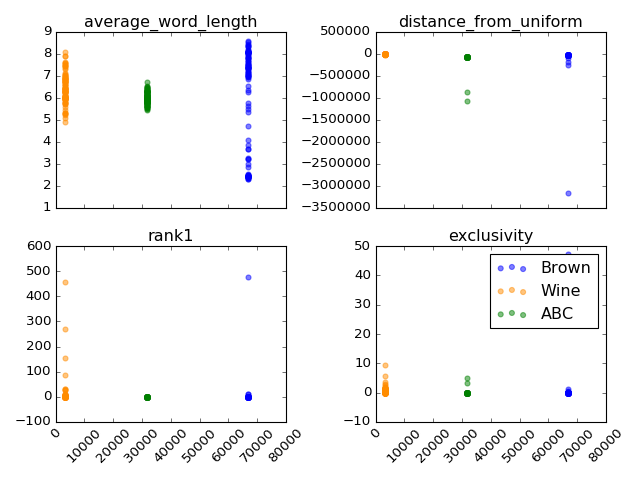

<IPython.core.display.Javascript object>


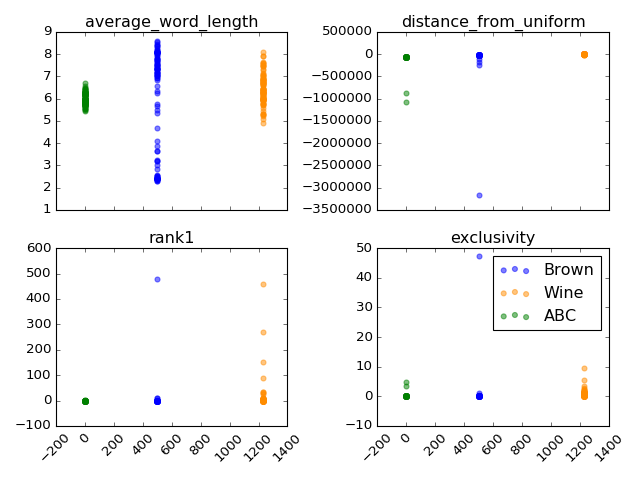

<IPython.core.display.Javascript object>


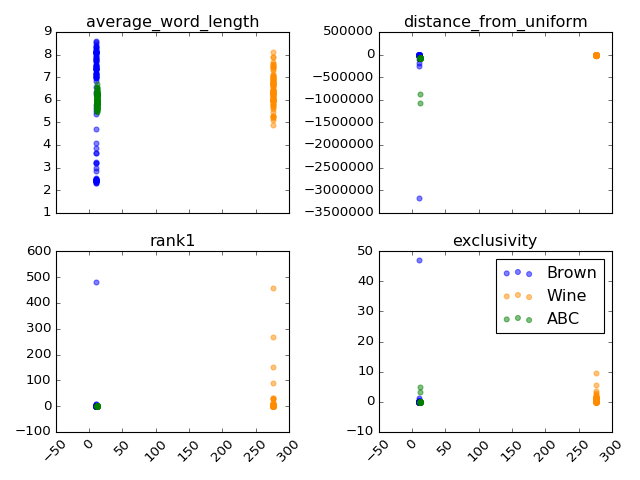

<IPython.core.display.Javascript object>


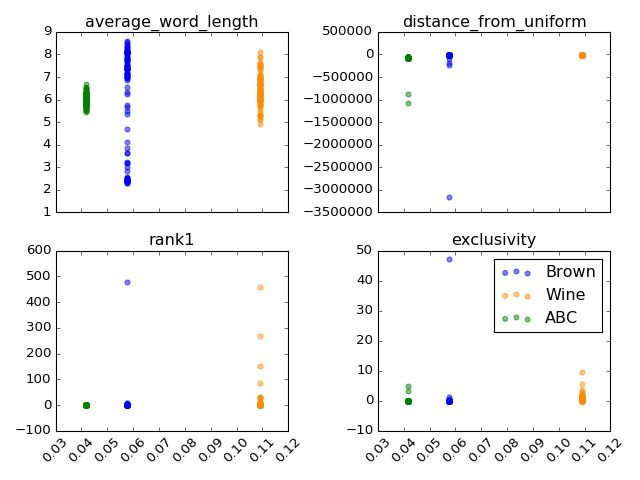

<IPython.core.display.Javascript object>


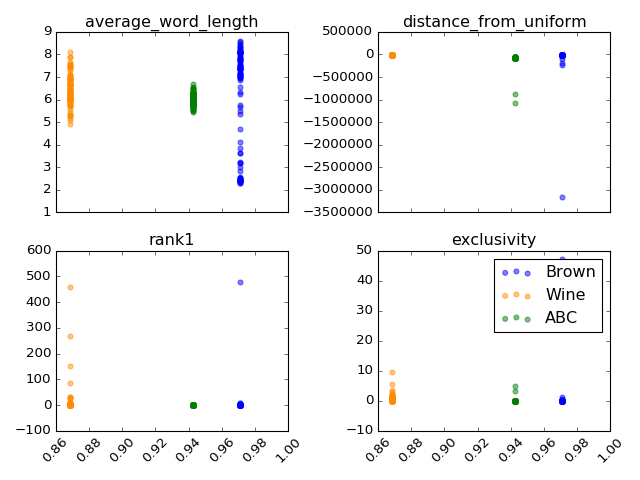

<IPython.core.display.Javascript object>


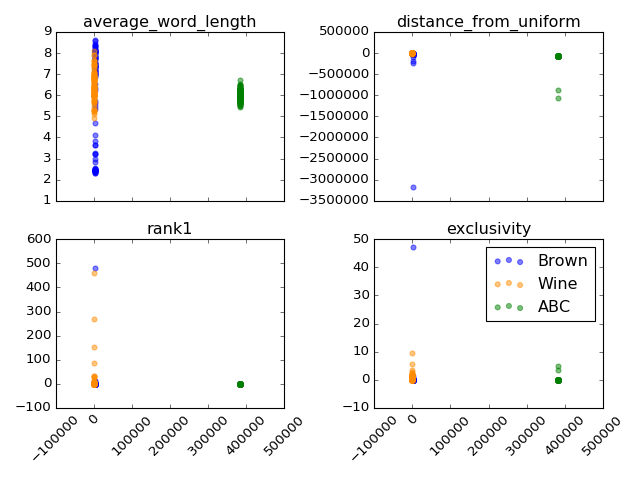

<IPython.core.display.Javascript object>


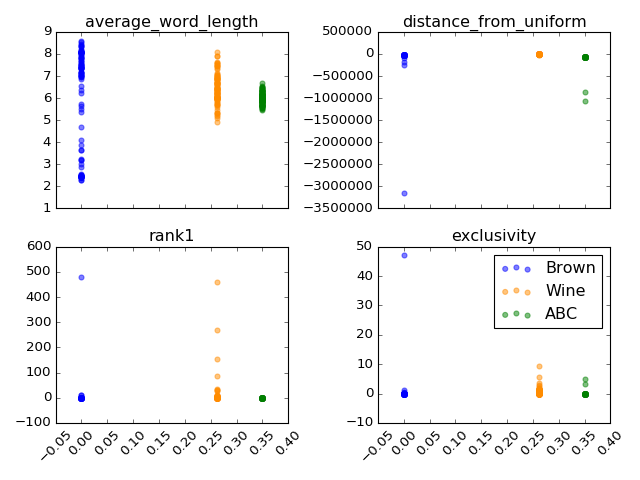

In [307]:
for prop in prop_dic:
    x_brown = [prop_dic[prop][0]]*k
    x_wine = [prop_dic[prop][1]]*k
    x_abc = [prop_dic[prop][2]]*k
    plot_property(prop,x_brown,x_wine,x_abc)

<IPython.core.display.Javascript object>


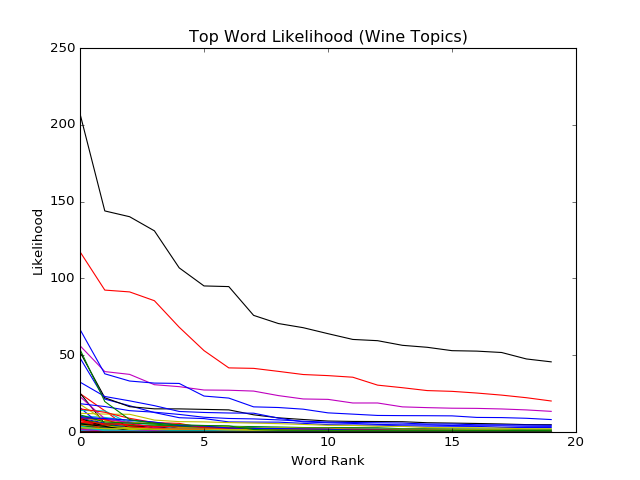

In [323]:
plt.figure()
plt.title("Top Word Likelihood (Wine Topics)")

for k in range(100):
    top_words_idx = wine_topic_word[k].argsort()[:-20-1:-1]
    x = np.arange(20)
    y = [wine_topic_word[k][i] for i in top_words_idx]
    plt.plot(x,y)
plt.ylabel("Likelihood")
plt.xlabel("Word Rank")
plt.savefig('figures/wine_word_likelihood.png',dpi=300)
plt.show()